<a href="https://colab.research.google.com/github/DhrubaAdhikary/MonocularVision/blob/master/Calculating_ROtation_and_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-contrib-python


Recovered Rotation:
 [[ 9.99997502e-01  1.16777109e-03  1.90584322e-03]
 [-1.16836288e-03  9.99999270e-01  3.09428914e-04]
 [-1.90548049e-03 -3.11654858e-04  9.99998136e-01]]
Recovered Translation:
 [[ 0.15172653]
 [ 0.01282118]
 [-0.98833935]]


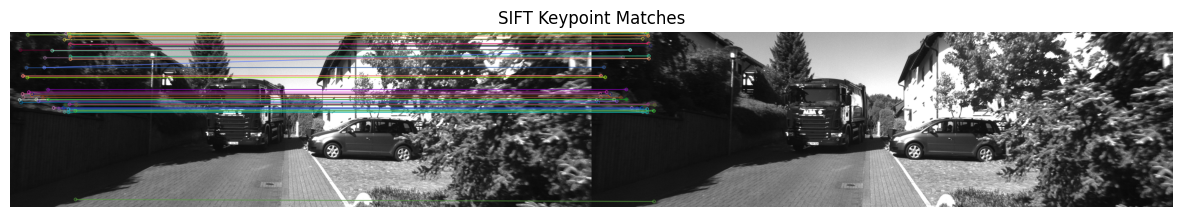

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sift_ransac_visual_odometry(img1_path, img2_path, focal=718.8560, pp=(607.1928, 185.2157)):
    # Load grayscale images
    img1 = cv2.imread(img1_path, 0)
    img2 = cv2.imread(img2_path, 0)

    # SIFT detector
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # Lowe's Ratio Test
    good_matches = []
    pts1 = []
    pts2 = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
            pts1.append(kp1[m.queryIdx].pt)
            pts2.append(kp2[m.trainIdx].pt)

    pts1 = np.array(pts1)
    pts2 = np.array(pts2)

    # Essential Matrix using RANSAC
    E, mask = cv2.findEssentialMat(pts2, pts1, focal=focal, pp=pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, focal=focal, pp=pp)

    print("Recovered Rotation:\n", R)
    print("Recovered Translation:\n", t)

    # Visualization
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches[:50], None, flags=2)
    plt.figure(figsize=(15, 10))
    plt.imshow(img_matches)
    plt.title("SIFT Keypoint Matches")
    plt.axis('off')
    plt.show()

    return R, t

# Example usage:
R, t = sift_ransac_visual_odometry("/content/001188.png", "/content/001189.png")
